# Gagnarannsóknir
Sjá `README.md` til þess að keyra þetta vélrit (e. notebook).

Í þessu vélriti eru gögnini skoðuð og ýmsar tilgátur prófaðar. Hugmyndin er að prófa ýmiskonar forvinnsluaðferðir fyrir Moses hér og svo útfæra í heild í öðru vélriti.

Það er gert ráð fyrir því að öll gögn séu aðgengileg undir `/work/data`. Sjá leiðbeiningar í `README.md` um hvernig það er gert með `docker` eða `singularity`.

Safnið `corpus.py` skilgreinir föll og gagnategundir sem eru mikið nýttar hér.

In [1]:
from collections import defaultdict, Counter, OrderedDict
import os
import pathlib
from pathlib import Path
import re
from pprint import pprint
import importlib
from typing import List, Sequence

import matplotlib.pyplot as plt
import numpy as np

import corpus.corpus as c

importlib.reload(c)

%matplotlib notebook

working_dir = pathlib.Path('/work')
data_dir = working_dir.joinpath('data')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff/haukurpj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff/haukurpj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's be sure that Moses is installed and the data is there.

In [2]:
print(os.getenv('MOSESDECODER'))
print(os.getenv('MOSESDECODER_TOOLS'))
print(int(os.getenv('THREADS')))
!ls {data_dir}

/opt/moses
/opt/moses_tools
40
bin  parice  risamalheild


In [3]:
# List of stages in processing
CAT = 'cat'
SHUFFLE = 'shuffle'
REGEXP = 'regexp'
SENT_FIX = 'sent_fix'
LOWER = 'lower'
TOKENIZE = 'tok'
PLACEHOLDERS = 'placeholders'
LENGTH = 'length'
DROP = 'drop'
LM = 'lm-blm'
KVISTUR = 'kvistur'
TRAIN = 'train'
TEST = 'test'
VAL = 'val'
FINAL = 'final'
TRANSLATED_EN_IS = 'translated_en_is'
TRANSLATED_IS_EN = 'translated_is_en'

parice_dir = data_dir.joinpath('parice')
rmh_dir = data_dir.joinpath('risamalheild')
train_parice_dir = parice_dir.joinpath('train')
test_parice_dir = parice_dir.joinpath('test')
val_parice_dir = parice_dir.joinpath('val')

!mkdir -p {train_parice_dir}
!mkdir -p {test_parice_dir}
!mkdir -p {val_parice_dir}

pipeline = [
    SHUFFLE,
    LOWER, 
    REGEXP, 
    TOKENIZE,
    PLACEHOLDERS,
    LENGTH,
    LM,
    FINAL,
    DROP,
    KVISTUR,
    TRANSLATED_EN_IS,
    TRANSLATED_IS_EN
]
rmh_stages = [
    SENT_FIX,
    LOWER,
    REGEXP,
    TOKENIZE,
    PLACEHOLDERS,
    LM,
    FINAL,
    CAT
]
parice_pipeline = [
    CAT,
    SENT_FIX,
    SHUFFLE
]

# If we are not starting from scratch - we try to load all intermediary stages
en_parice = c.pipeline_load(parice_dir, parice_pipeline, c.Lang.EN)
is_parice = c.pipeline_load(parice_dir, parice_pipeline, c.Lang.IS)
en_train = c.pipeline_load(train_parice_dir, pipeline, c.Lang.EN)
is_train = c.pipeline_load(train_parice_dir, pipeline, c.Lang.IS)
en_test = c.pipeline_load(test_parice_dir, pipeline, c.Lang.EN)
is_test = c.pipeline_load(test_parice_dir, pipeline, c.Lang.IS)
en_val = c.pipeline_load(val_parice_dir, pipeline, c.Lang.EN)
is_val = c.pipeline_load(val_parice_dir, pipeline, c.Lang.IS)
rmh = c.pipeline_load(rmh_dir, rmh_stages, c.Lang.IS)
pprint(en_parice)
pprint(is_parice)
pprint(rmh)
pprint(en_train)
pprint(is_train)

{'cat': PosixPath('/work/data/parice/cat.en'),
 'sent_fix': PosixPath('/work/data/parice/sent_fix.en'),
 'shuffle': PosixPath('/work/data/parice/shuffle.en')}
{'cat': PosixPath('/work/data/parice/cat.is'),
 'sent_fix': PosixPath('/work/data/parice/sent_fix.is'),
 'shuffle': PosixPath('/work/data/parice/shuffle.is')}
{'cat': PosixPath('/work/data/risamalheild/cat.is'),
 'final': PosixPath('/work/data/risamalheild/final.is'),
 'lm-blm': PosixPath('/work/data/risamalheild/lm-blm.is'),
 'lower': PosixPath('/work/data/risamalheild/lower.is'),
 'placeholders': None,
 'regexp': PosixPath('/work/data/risamalheild/regexp.is'),
 'sent_fix': PosixPath('/work/data/risamalheild/sent_fix.is'),
 'tok': PosixPath('/work/data/risamalheild/tok.is')}
{'drop': PosixPath('/work/data/parice/train/drop.en'),
 'final': PosixPath('/work/data/parice/train/final.en'),
 'kvistur': None,
 'length': PosixPath('/work/data/parice/train/length.en'),
 'lm-blm': PosixPath('/work/data/parice/train/lm-blm.en'),
 'lower': 

In [10]:
def print_line(line_number, corpus):
    result = !sed '{line_number}q;d' {corpus}
    return result[0]

## Einhliða málheild fyrir íslensku - RMH
Fyrir RMH lesum við öll tei-XML skjölin úr RMH1 og RMH2 og sameinum í eitt skjal. Þessi gögn eru aðgengileg á Terra undir `/data/risamalheild/` eða `/scratch/smt/data/risamalheild`. Í kóðanum er gert ráð fyrir að hún sé aðgengileg undir `/work/data/risamalheild/`.

In [51]:
xml_files = !find {rmh_dir} -name '*.xml' ! -name 'rmh2Hdr.xml' ! -name 'rmh1Hdr.xml' # This takes very long (>30 mins)
xml_files = [Path(xml_file) for xml_file in xml_files]

In [108]:
!head {xml_files[0]}

<?xml version="1.0" encoding="utf-8"?>
<TEI xmlns="http://www.tei-c.org/ns/1.0">
  <teiHeader>
    <fileDesc>
      <titleStmt>
        <title>
          <title type="main">söluskattur</title>
        </title>
        <respStmt>
          <resp xml:lang="is">Söfnun og úrvinnsla texta</resp>


In [96]:
rmh_txt = rmh_dir.joinpath('rmh.is')
c.read_tei(xml_files, rmh_txt)



  0%|          | 0/4152478 [00:00<?, ?it/s]

  0%|          | 1401/4152478 [00:00<29:27, 2349.10it/s]

  0%|          | 2301/4152478 [00:00<23:04, 2997.73it/s]

  0%|          | 3101/4152478 [00:00<19:26, 3556.83it/s]

  0%|          | 4401/4152478 [00:00<15:39, 4417.40it/s]

  0%|          | 5601/4152478 [00:01<13:16, 5206.31it/s]

  0%|          | 6279/4152478 [00:01<12:44, 5423.06it/s]

  0%|          | 7001/4152478 [00:01<11:50, 5833.12it/s]

  0%|          | 7672/4152478 [00:01<11:55, 5792.08it/s]

  0%|          | 8501/4152478 [00:01<12:47, 5396.61it/s]

  0%|          | 9901/4152478 [00:01<11:04, 6234.08it/s]

  0%|          | 10801/4152478 [00:01<10:13, 6747.25it/s]

  0%|          | 11545/4152478 [00:01<10:12, 6762.85it/s]

  0%|          | 12270/4152478 [00:02<10:42, 6447.49it/s]

  0%|          | 13001/4152478 [00:02<10:32, 6544.40it/s]

  0%|          | 13901/4152478 [00:02<09:46, 7061.10it/s]

  0%|          | 14638/4152478 [00:02<09:55, 6952.36it/s]

  0%|          | 15

  6%|▌         | 249301/4152478 [01:12<09:50, 6615.10it/s]

  6%|▌         | 250001/4152478 [01:12<17:46, 3659.55it/s]

  6%|▌         | 250545/4152478 [01:16<2:21:21, 460.07it/s]

  6%|▌         | 253901/4152478 [01:17<1:45:18, 617.05it/s]

  6%|▌         | 254501/4152478 [01:17<1:21:33, 796.62it/s]

  6%|▌         | 255501/4152478 [01:17<59:07, 1098.42it/s] 

  6%|▌         | 257301/4152478 [01:19<55:56, 1160.52it/s]

  6%|▌         | 259401/4152478 [01:20<48:01, 1351.24it/s]

  6%|▋         | 267801/4152478 [01:20<33:53, 1910.54it/s]

  6%|▋         | 269719/4152478 [01:20<30:40, 2109.30it/s]

  7%|▋         | 271145/4152478 [01:21<25:37, 2524.54it/s]

  7%|▋         | 272284/4152478 [01:21<22:42, 2848.57it/s]

  7%|▋         | 273203/4152478 [01:21<23:35, 2740.86it/s]

  7%|▋         | 273922/4152478 [01:22<21:30, 3004.65it/s]

  7%|▋         | 274542/4152478 [01:22<23:07, 2794.51it/s]

  7%|▋         | 275048/4152478 [01:22<20:22, 3171.38it/s]

  7%|▋         | 275541/4152478 [01:

 11%|█         | 454913/4152478 [03:38<19:48, 3111.77it/s]

 11%|█         | 455801/4152478 [03:38<16:30, 3731.88it/s]

 11%|█         | 456340/4152478 [03:38<16:16, 3785.91it/s]

 11%|█         | 457201/4152478 [03:38<15:16, 4029.89it/s]

 11%|█         | 457690/4152478 [03:40<1:10:44, 870.55it/s]

 11%|█         | 458101/4152478 [03:40<54:49, 1123.16it/s] 

 11%|█         | 458801/4152478 [03:40<42:29, 1448.59it/s]

 11%|█         | 459181/4152478 [03:41<1:28:30, 695.44it/s]

 11%|█         | 460001/4152478 [03:41<1:07:20, 913.81it/s]

 11%|█         | 460297/4152478 [03:43<2:39:18, 386.27it/s]

 11%|█         | 461401/4152478 [03:43<1:53:59, 539.66it/s]

 11%|█         | 462001/4152478 [03:43<1:23:22, 737.73it/s]

 11%|█         | 462801/4152478 [03:43<1:00:45, 1012.03it/s]

 11%|█         | 463401/4152478 [03:44<46:09, 1332.26it/s]  

 11%|█         | 464201/4152478 [03:44<34:51, 1763.67it/s]

 11%|█         | 464801/4152478 [03:44<27:41, 2219.43it/s]

 11%|█         | 465601/41524

 14%|█▍        | 596701/4152478 [06:17<55:19, 1071.07it/s]

 14%|█▍        | 597101/4152478 [06:17<43:36, 1358.65it/s]

 14%|█▍        | 597701/4152478 [06:17<33:49, 1751.18it/s]

 14%|█▍        | 598401/4152478 [06:17<27:21, 2165.35it/s]

 14%|█▍        | 599001/4152478 [06:17<22:24, 2643.29it/s]

 14%|█▍        | 599457/4152478 [06:19<1:16:42, 772.06it/s]

 14%|█▍        | 599901/4152478 [06:19<59:07, 1001.38it/s] 

 14%|█▍        | 600601/4152478 [06:19<44:16, 1337.14it/s]

 14%|█▍        | 601201/4152478 [06:19<34:27, 1717.76it/s]

 14%|█▍        | 601701/4152478 [06:19<27:44, 2133.46it/s]

 15%|█▍        | 602159/4152478 [06:21<1:19:55, 740.40it/s]

 15%|█▍        | 602601/4152478 [06:21<1:01:11, 967.00it/s]

 15%|█▍        | 602933/4152478 [06:21<49:04, 1205.68it/s] 

 15%|█▍        | 603601/4152478 [06:21<36:59, 1598.70it/s]

 15%|█▍        | 604101/4152478 [06:21<30:37, 1931.06it/s]

 15%|█▍        | 604510/4152478 [06:23<1:31:37, 645.38it/s]

 15%|█▍        | 605401/4152478 [0

 18%|█▊        | 741601/4152478 [08:30<58:38, 969.44it/s]  

 18%|█▊        | 742301/4152478 [08:30<44:48, 1268.57it/s]

 18%|█▊        | 743001/4152478 [08:32<1:12:04, 788.34it/s]

 18%|█▊        | 743301/4152478 [08:33<2:22:52, 397.70it/s]

 18%|█▊        | 743801/4152478 [08:35<2:48:59, 336.18it/s]

 18%|█▊        | 744301/4152478 [08:36<2:04:22, 456.69it/s]

 18%|█▊        | 744501/4152478 [08:36<1:37:58, 579.70it/s]

 18%|█▊        | 745001/4152478 [08:36<1:12:06, 787.54it/s]

 18%|█▊        | 745270/4152478 [08:36<58:58, 962.80it/s]  

 18%|█▊        | 745701/4152478 [08:36<46:26, 1222.75it/s]

 18%|█▊        | 745974/4152478 [08:36<39:38, 1431.99it/s]

 18%|█▊        | 746237/4152478 [08:38<2:08:40, 441.19it/s]

 18%|█▊        | 746601/4152478 [08:38<1:37:00, 585.20it/s]

 18%|█▊        | 747101/4152478 [08:38<1:12:51, 779.01it/s]

 18%|█▊        | 747348/4152478 [08:38<58:00, 978.21it/s]  

 18%|█▊        | 747901/4152478 [08:40<1:32:18, 614.71it/s]

 18%|█▊        | 748201/415

 21%|██▏       | 891901/4152478 [10:52<1:57:59, 460.55it/s]

 21%|██▏       | 892301/4152478 [10:53<1:27:49, 618.73it/s]

 22%|██▏       | 892901/4152478 [10:53<1:04:23, 843.73it/s]

 22%|██▏       | 893301/4152478 [10:53<49:13, 1103.62it/s] 

 22%|██▏       | 893701/4152478 [10:53<38:45, 1401.35it/s]

 22%|██▏       | 894080/4152478 [10:54<1:35:50, 566.65it/s]

 22%|██▏       | 894601/4152478 [10:55<1:10:38, 768.60it/s]

 22%|██▏       | 894929/4152478 [10:57<2:35:36, 348.89it/s]

 22%|██▏       | 897701/4152478 [10:57<1:49:33, 495.11it/s]

 22%|██▏       | 898537/4152478 [10:59<1:50:00, 493.00it/s]

 22%|██▏       | 899137/4152478 [10:59<1:20:23, 674.48it/s]

 22%|██▏       | 899700/4152478 [10:59<59:35, 909.80it/s]  

 22%|██▏       | 900241/4152478 [10:59<45:42, 1185.74it/s]

 22%|██▏       | 900742/4152478 [11:05<3:34:16, 252.92it/s]

 22%|██▏       | 901201/4152478 [11:05<2:35:38, 348.14it/s]

 22%|██▏       | 901701/4152478 [11:05<1:52:27, 481.78it/s]

 22%|██▏       | 902301/41

 26%|██▌       | 1071501/4152478 [14:04<1:10:05, 732.59it/s]

 26%|██▌       | 1072001/4152478 [14:04<52:10, 983.92it/s]  

 26%|██▌       | 1072901/4152478 [14:04<38:49, 1322.25it/s]

 26%|██▌       | 1073701/4152478 [14:06<58:47, 872.84it/s] 

 26%|██▌       | 1074301/4152478 [14:06<45:35, 1125.10it/s]

 26%|██▌       | 1075101/4152478 [14:06<34:36, 1482.03it/s]

 26%|██▌       | 1075701/4152478 [14:07<27:55, 1835.90it/s]

 26%|██▌       | 1076131/4152478 [14:08<1:16:03, 674.07it/s]

 26%|██▌       | 1076901/4152478 [14:08<55:22, 925.71it/s]  

 26%|██▌       | 1077333/4152478 [14:08<44:49, 1143.37it/s]

 26%|██▌       | 1078401/4152478 [14:08<33:01, 1551.19it/s]

 26%|██▌       | 1078944/4152478 [14:10<1:12:40, 704.92it/s]

 26%|██▌       | 1079901/4152478 [14:10<53:14, 961.90it/s]  

 26%|██▌       | 1080367/4152478 [14:11<41:35, 1231.23it/s]

 26%|██▌       | 1080800/4152478 [14:14<2:36:42, 326.70it/s]

 26%|██▌       | 1081301/4152478 [14:14<1:53:32, 450.81it/s]

 26%|██▌       |

 30%|██▉       | 1225801/4152478 [16:15<1:41:15, 481.72it/s]

 30%|██▉       | 1226501/4152478 [16:15<1:20:26, 606.29it/s]

 30%|██▉       | 1226659/4152478 [16:23<12:48:23, 63.46it/s]

 30%|██▉       | 1226771/4152478 [16:23<9:48:03, 82.92it/s] 

 30%|██▉       | 1226858/4152478 [16:25<11:20:56, 71.61it/s]

 30%|██▉       | 1226921/4152478 [16:25<8:22:06, 97.11it/s] 

 30%|██▉       | 1227001/4152478 [16:25<6:17:03, 129.31it/s]

 30%|██▉       | 1227101/4152478 [16:29<13:46:15, 59.01it/s]

 30%|██▉       | 1227201/4152478 [16:30<10:33:41, 76.94it/s]

 30%|██▉       | 1227501/4152478 [16:31<8:45:49, 92.71it/s] 

 30%|██▉       | 1228001/4152478 [16:40<10:10:10, 79.88it/s]

 30%|██▉       | 1228201/4152478 [16:41<9:15:52, 87.68it/s] 

 30%|██▉       | 1228301/4152478 [16:52<31:42:21, 25.62it/s]

 30%|██▉       | 1229301/4152478 [16:53<22:35:55, 35.93it/s]

 30%|██▉       | 1229401/4152478 [16:59<29:07:22, 27.88it/s]

 30%|██▉       | 1230201/4152478 [17:00<20:53:52, 38.84it/s]

 30%|██▉

 32%|███▏      | 1344013/4152478 [23:19<49:17, 949.72it/s] 

 32%|███▏      | 1344801/4152478 [23:19<36:22, 1286.72it/s]

 32%|███▏      | 1345333/4152478 [23:19<28:37, 1634.70it/s]

 32%|███▏      | 1345839/4152478 [23:20<24:50, 1882.55it/s]

 32%|███▏      | 1346281/4152478 [23:21<1:06:40, 701.38it/s]

 32%|███▏      | 1346599/4152478 [23:25<3:14:40, 240.22it/s]

 32%|███▏      | 1346824/4152478 [23:25<2:23:42, 325.38it/s]

 32%|███▏      | 1347401/4152478 [23:25<1:43:08, 453.28it/s]

 32%|███▏      | 1348001/4152478 [23:25<1:15:28, 619.34it/s]

 32%|███▏      | 1348501/4152478 [23:25<56:02, 833.78it/s]  

 32%|███▏      | 1349201/4152478 [23:25<41:49, 1117.00it/s]

 33%|███▎      | 1349625/4152478 [23:25<32:39, 1430.63it/s]

 33%|███▎      | 1350501/4152478 [23:25<25:12, 1852.20it/s]

 33%|███▎      | 1351001/4152478 [23:26<21:31, 2169.55it/s]

 33%|███▎      | 1351601/4152478 [23:26<17:39, 2644.41it/s]

 33%|███▎      | 1352071/4152478 [23:27<1:00:51, 766.83it/s]

 33%|███▎      | 

 36%|███▌      | 1488383/4152478 [25:59<36:11, 1226.74it/s]

 36%|███▌      | 1489301/4152478 [26:04<1:36:18, 460.88it/s]

 36%|███▌      | 1489593/4152478 [26:04<1:15:31, 587.61it/s]

 36%|███▌      | 1490401/4152478 [26:06<1:23:33, 530.99it/s]

 36%|███▌      | 1490801/4152478 [26:06<1:03:13, 701.69it/s]

 36%|███▌      | 1491019/4152478 [26:07<1:50:25, 401.70it/s]

 36%|███▌      | 1491901/4152478 [26:07<1:18:51, 562.32it/s]

 36%|███▌      | 1492264/4152478 [26:07<1:00:07, 737.34it/s]

 36%|███▌      | 1492599/4152478 [26:07<46:59, 943.42it/s]  

 36%|███▌      | 1493501/4152478 [26:07<34:43, 1276.10it/s]

 36%|███▌      | 1493938/4152478 [26:08<29:18, 1511.82it/s]

 36%|███▌      | 1494901/4152478 [26:08<22:14, 1991.19it/s]

 36%|███▌      | 1495401/4152478 [26:08<20:04, 2205.13it/s]

 36%|███▌      | 1496001/4152478 [26:10<48:41, 909.13it/s] 

 36%|███▌      | 1496401/4152478 [26:10<38:07, 1161.18it/s]

 36%|███▌      | 1496723/4152478 [26:10<30:56, 1430.13it/s]

 36%|███▌      |

 39%|███▉      | 1629901/4152478 [29:12<37:57, 1107.63it/s]

 39%|███▉      | 1630236/4152478 [29:19<4:38:52, 150.74it/s]

 39%|███▉      | 1630901/4152478 [29:19<3:17:19, 212.98it/s]

 39%|███▉      | 1631241/4152478 [29:19<2:35:26, 270.33it/s]

 39%|███▉      | 1631501/4152478 [29:21<3:13:19, 217.33it/s]

 39%|███▉      | 1632001/4152478 [29:21<2:17:58, 304.47it/s]

 39%|███▉      | 1632401/4152478 [29:26<3:55:26, 178.40it/s]

 39%|███▉      | 1634001/4152478 [29:27<2:59:06, 234.34it/s]

 39%|███▉      | 1634201/4152478 [29:28<2:14:27, 312.15it/s]

 39%|███▉      | 1635101/4152478 [29:28<1:35:59, 437.06it/s]

 39%|███▉      | 1635408/4152478 [29:28<1:16:01, 551.78it/s]

 39%|███▉      | 1635665/4152478 [29:35<6:45:02, 103.56it/s]

 39%|███▉      | 1635901/4152478 [29:35<4:50:06, 144.57it/s]

 39%|███▉      | 1636301/4152478 [29:35<3:27:33, 202.05it/s]

 39%|███▉      | 1636601/4152478 [29:35<2:29:43, 280.04it/s]

 39%|███▉      | 1636835/4152478 [29:36<1:51:31, 375.97it/s]

 39%|███▉

 42%|████▏     | 1758001/4152478 [32:47<4:27:41, 149.08it/s]

 42%|████▏     | 1758301/4152478 [32:47<3:12:25, 207.37it/s]

 42%|████▏     | 1758701/4152478 [32:47<2:19:57, 285.04it/s]

 42%|████▏     | 1759401/4152478 [32:48<1:40:04, 398.55it/s]

 42%|████▏     | 1759801/4152478 [32:48<1:13:13, 544.58it/s]

 42%|████▏     | 1760151/4152478 [32:48<56:51, 701.23it/s]  

 42%|████▏     | 1760801/4152478 [32:48<42:48, 931.28it/s]

 42%|████▏     | 1761301/4152478 [32:48<32:25, 1229.20it/s]

 42%|████▏     | 1761681/4152478 [32:50<1:16:11, 522.95it/s]

 42%|████▏     | 1762101/4152478 [32:50<57:09, 697.07it/s]  

 42%|████▏     | 1762801/4152478 [32:50<42:04, 946.58it/s]

 42%|████▏     | 1763173/4152478 [32:52<1:23:01, 479.65it/s]

 42%|████▏     | 1763601/4152478 [32:55<2:29:53, 265.63it/s]

 42%|████▏     | 1764101/4152478 [32:55<1:47:57, 368.71it/s]

 42%|████▏     | 1764401/4152478 [32:55<1:21:01, 491.18it/s]

 42%|████▏     | 1764801/4152478 [32:55<1:00:06, 662.00it/s]

 43%|████▎   

 45%|████▌     | 1878266/4152478 [35:59<1:03:20, 598.32it/s]

 45%|████▌     | 1878501/4152478 [36:00<1:45:03, 360.74it/s]

 45%|████▌     | 1878901/4152478 [36:01<1:17:09, 491.11it/s]

 45%|████▌     | 1879109/4152478 [36:01<1:00:50, 622.81it/s]

 45%|████▌     | 1879601/4152478 [36:01<45:12, 837.96it/s]  

 45%|████▌     | 1880101/4152478 [36:01<33:58, 1114.94it/s]

 45%|████▌     | 1880434/4152478 [36:01<28:52, 1311.49it/s]

 45%|████▌     | 1880734/4152478 [36:01<24:42, 1532.06it/s]

 45%|████▌     | 1881301/4152478 [36:08<2:24:02, 262.78it/s]

 45%|████▌     | 1881901/4152478 [36:08<1:43:03, 367.17it/s]

 45%|████▌     | 1882194/4152478 [36:08<1:18:30, 481.95it/s]

 45%|████▌     | 1882701/4152478 [36:08<59:33, 635.19it/s]  

 45%|████▌     | 1883201/4152478 [36:08<44:28, 850.41it/s]

 45%|████▌     | 1883502/4152478 [36:08<37:06, 1019.27it/s]

 45%|████▌     | 1884101/4152478 [36:08<29:13, 1293.81it/s]

 45%|████▌     | 1884601/4152478 [36:09<23:01, 1641.46it/s]

 45%|████▌     |

 48%|████▊     | 1987626/4152478 [39:08<1:41:45, 354.55it/s]

 48%|████▊     | 1988201/4152478 [39:09<1:16:19, 472.60it/s]

 48%|████▊     | 1988601/4152478 [39:10<1:36:49, 372.47it/s]

 48%|████▊     | 1989001/4152478 [39:10<1:10:33, 511.06it/s]

 48%|████▊     | 1989601/4152478 [39:11<53:07, 678.49it/s]  

 48%|████▊     | 1990001/4152478 [39:11<40:06, 898.48it/s]

 48%|████▊     | 1990308/4152478 [39:12<1:26:58, 414.30it/s]

 48%|████▊     | 1991001/4152478 [39:13<1:04:58, 554.51it/s]

 48%|████▊     | 1991235/4152478 [39:13<50:42, 710.34it/s]  

 48%|████▊     | 1991701/4152478 [39:14<1:11:53, 500.97it/s]

 48%|████▊     | 1992401/4152478 [39:15<54:27, 661.03it/s]  

 48%|████▊     | 1992701/4152478 [39:15<42:12, 852.93it/s]

 48%|████▊     | 1993101/4152478 [39:16<1:14:20, 484.06it/s]

 48%|████▊     | 1993801/4152478 [39:17<55:57, 643.02it/s]  

 48%|████▊     | 1993995/4152478 [39:20<3:49:49, 156.53it/s]

 48%|████▊     | 1994501/4152478 [39:20<2:44:07, 219.14it/s]

 48%|████▊  

 51%|█████     | 2112501/4152478 [42:30<29:45, 1142.64it/s]

 51%|█████     | 2112809/4152478 [42:34<2:12:54, 255.79it/s]

 51%|█████     | 2113401/4152478 [42:34<1:36:02, 353.83it/s]

 51%|█████     | 2113901/4152478 [42:34<1:09:22, 489.74it/s]

 51%|█████     | 2114220/4152478 [42:34<52:47, 643.56it/s]  

 51%|█████     | 2114701/4152478 [42:34<39:05, 868.86it/s]

 51%|█████     | 2115051/4152478 [42:34<30:42, 1105.93it/s]

 51%|█████     | 2115601/4152478 [42:34<25:03, 1354.58it/s]

 51%|█████     | 2115922/4152478 [42:36<55:05, 616.11it/s] 

 51%|█████     | 2116201/4152478 [42:36<44:20, 765.35it/s]

 51%|█████     | 2116417/4152478 [42:42<5:08:56, 109.84it/s]

 51%|█████     | 2117001/4152478 [42:44<4:11:41, 134.78it/s]

 51%|█████     | 2117301/4152478 [42:44<2:59:46, 188.68it/s]

 51%|█████     | 2117601/4152478 [42:46<3:12:13, 176.44it/s]

 51%|█████     | 2117901/4152478 [42:48<3:22:18, 167.61it/s]

 51%|█████     | 2118401/4152478 [42:48<2:25:33, 232.91it/s]

 51%|█████     |

 54%|█████▍    | 2232318/4152478 [45:44<4:21:18, 122.47it/s]

 54%|█████▍    | 2232871/4152478 [45:45<3:29:55, 152.40it/s]

 54%|█████▍    | 2233269/4152478 [45:47<3:14:18, 164.63it/s]

 54%|█████▍    | 2233554/4152478 [45:48<2:22:53, 223.82it/s]

 54%|█████▍    | 2234101/4152478 [45:48<1:42:22, 312.32it/s]

 54%|█████▍    | 2234501/4152478 [45:51<2:36:46, 203.90it/s]

 54%|█████▍    | 2234801/4152478 [45:51<1:53:09, 282.46it/s]

 54%|█████▍    | 2235201/4152478 [45:51<1:21:49, 390.52it/s]

 54%|█████▍    | 2235501/4152478 [45:55<2:58:00, 179.48it/s]

 54%|█████▍    | 2235901/4152478 [45:59<3:40:06, 145.12it/s]

 54%|█████▍    | 2236201/4152478 [45:59<2:38:22, 201.66it/s]

 54%|█████▍    | 2236401/4152478 [46:03<4:58:12, 107.09it/s]

 54%|█████▍    | 2237001/4152478 [46:03<3:30:47, 151.45it/s]

 54%|█████▍    | 2237301/4152478 [46:05<3:29:00, 152.72it/s]

 54%|█████▍    | 2237458/4152478 [46:05<2:32:26, 209.36it/s]

 54%|█████▍    | 2237701/4152478 [46:06<1:52:56, 282.57it/s]

 54%|███

 57%|█████▋    | 2351826/4152478 [49:44<51:26, 583.31it/s]  

 57%|█████▋    | 2352301/4152478 [49:44<38:19, 782.85it/s]

 57%|█████▋    | 2352565/4152478 [49:47<2:23:26, 209.15it/s]

 57%|█████▋    | 2353101/4152478 [49:47<1:44:02, 288.24it/s]

 57%|█████▋    | 2353306/4152478 [49:47<1:17:26, 387.22it/s]

 57%|█████▋    | 2353901/4152478 [49:48<56:16, 532.69it/s]  

 57%|█████▋    | 2354172/4152478 [49:51<2:35:56, 192.19it/s]

 57%|█████▋    | 2354501/4152478 [49:51<1:54:11, 262.43it/s]

 57%|█████▋    | 2354901/4152478 [49:51<1:22:31, 363.07it/s]

 57%|█████▋    | 2355401/4152478 [49:52<1:00:38, 493.97it/s]

 57%|█████▋    | 2355901/4152478 [49:52<44:53, 667.09it/s]  

 57%|█████▋    | 2356201/4152478 [49:53<1:15:12, 398.04it/s]

 57%|█████▋    | 2356411/4152478 [49:55<2:33:35, 194.89it/s]

 57%|█████▋    | 2358101/4152478 [49:56<1:48:08, 276.56it/s]

 57%|█████▋    | 2358578/4152478 [49:56<1:18:47, 379.49it/s]

 57%|█████▋    | 2358999/4152478 [49:57<1:30:56, 328.67it/s]

 57%|█████

 59%|█████▉    | 2461701/4152478 [52:45<1:47:10, 262.95it/s]

 59%|█████▉    | 2462101/4152478 [52:45<1:17:21, 364.16it/s]

 59%|█████▉    | 2462801/4152478 [52:45<55:20, 508.85it/s]  

 59%|█████▉    | 2463235/4152478 [52:47<1:13:57, 380.68it/s]

 59%|█████▉    | 2463546/4152478 [52:47<54:31, 516.23it/s]  

 59%|█████▉    | 2464401/4152478 [52:49<53:59, 521.12it/s]

 59%|█████▉    | 2464634/4152478 [52:49<46:46, 601.35it/s]

 59%|█████▉    | 2464901/4152478 [52:49<35:57, 782.36it/s]

 59%|█████▉    | 2465114/4152478 [52:53<2:45:15, 170.17it/s]

 59%|█████▉    | 2467101/4152478 [52:53<1:55:58, 242.19it/s]

 59%|█████▉    | 2467788/4152478 [52:57<2:07:57, 219.42it/s]

 59%|█████▉    | 2468501/4152478 [52:57<1:31:05, 308.11it/s]

 59%|█████▉    | 2469004/4152478 [52:57<1:09:16, 405.07it/s]

 59%|█████▉    | 2469501/4152478 [52:57<50:45, 552.60it/s]  

 59%|█████▉    | 2470001/4152478 [52:59<1:04:43, 433.21it/s]

 59%|█████▉    | 2470401/4152478 [52:59<48:45, 574.89it/s]  

 60%|█████▉   

 62%|██████▏   | 2586842/4152478 [56:31<23:30, 1109.81it/s]

 62%|██████▏   | 2587501/4152478 [56:31<17:38, 1477.89it/s]

 62%|██████▏   | 2588101/4152478 [56:32<32:45, 795.98it/s] 

 62%|██████▏   | 2588488/4152478 [56:33<25:15, 1032.15it/s]

 62%|██████▏   | 2589501/4152478 [56:33<18:46, 1387.02it/s]

 62%|██████▏   | 2589972/4152478 [56:33<14:59, 1737.11it/s]

 62%|██████▏   | 2590901/4152478 [56:34<24:45, 1051.08it/s]

 62%|██████▏   | 2591237/4152478 [56:36<1:00:41, 428.77it/s]

 62%|██████▏   | 2592301/4152478 [56:36<43:31, 597.45it/s]  

 62%|██████▏   | 2592688/4152478 [56:37<32:53, 790.21it/s]

 62%|██████▏   | 2593701/4152478 [56:38<36:25, 713.08it/s]

 62%|██████▏   | 2593975/4152478 [56:42<2:18:28, 187.58it/s]

 62%|██████▏   | 2594401/4152478 [56:42<1:38:44, 263.00it/s]

 62%|██████▏   | 2595001/4152478 [56:43<1:10:50, 366.38it/s]

 63%|██████▎   | 2595318/4152478 [56:46<2:26:11, 177.52it/s]

 63%|██████▎   | 2595801/4152478 [56:47<1:44:01, 249.41it/s]

 63%|██████▎   | 25

 64%|██████▍   | 2655062/4152478 [58:13<35:53, 695.34it/s] 

 64%|██████▍   | 2655601/4152478 [58:13<26:47, 931.08it/s]

 64%|██████▍   | 2656101/4152478 [58:13<20:27, 1218.94it/s]

 64%|██████▍   | 2656601/4152478 [58:14<15:55, 1564.90it/s]

 64%|██████▍   | 2657101/4152478 [58:14<12:55, 1928.72it/s]

 64%|██████▍   | 2657515/4152478 [58:15<38:15, 651.26it/s] 

 64%|██████▍   | 2658101/4152478 [58:15<28:03, 887.43it/s]

 64%|██████▍   | 2658801/4152478 [58:16<20:54, 1190.94it/s]

 64%|██████▍   | 2659401/4152478 [58:16<15:58, 1557.86it/s]

 64%|██████▍   | 2659901/4152478 [58:17<35:15, 705.40it/s] 

 64%|██████▍   | 2660401/4152478 [58:17<26:10, 949.95it/s]

 64%|██████▍   | 2661101/4152478 [58:17<19:29, 1275.74it/s]

 64%|██████▍   | 2661701/4152478 [58:18<15:11, 1634.98it/s]

 64%|██████▍   | 2662401/4152478 [58:18<11:48, 2103.77it/s]

 64%|██████▍   | 2662920/4152478 [58:23<1:25:40, 289.77it/s]

 64%|██████▍   | 2663286/4152478 [58:23<1:03:00, 393.90it/s]

 64%|██████▍   | 2664101/

 67%|██████▋   | 2788001/4152478 [1:01:33<19:50, 1146.16it/s]

 67%|██████▋   | 2788401/4152478 [1:01:35<41:14, 551.21it/s] 

 67%|██████▋   | 2788801/4152478 [1:01:37<1:00:59, 372.60it/s]

 67%|██████▋   | 2789401/4152478 [1:01:37<43:58, 516.67it/s]  

 67%|██████▋   | 2790101/4152478 [1:01:37<32:20, 702.19it/s]

 67%|██████▋   | 2790501/4152478 [1:01:37<25:14, 899.26it/s]

 67%|██████▋   | 2791001/4152478 [1:01:39<38:24, 590.70it/s]

 67%|██████▋   | 2791501/4152478 [1:01:39<28:24, 798.41it/s]

 67%|██████▋   | 2791901/4152478 [1:01:39<22:59, 986.57it/s]

 67%|██████▋   | 2792301/4152478 [1:01:41<45:27, 498.61it/s]

 67%|██████▋   | 2792901/4152478 [1:01:41<33:30, 676.39it/s]

 67%|██████▋   | 2793301/4152478 [1:01:41<25:55, 873.67it/s]

 67%|██████▋   | 2793701/4152478 [1:01:41<20:08, 1124.79it/s]

 67%|██████▋   | 2794301/4152478 [1:01:41<15:33, 1454.65it/s]

 67%|██████▋   | 2794701/4152478 [1:01:41<12:37, 1793.24it/s]

 67%|██████▋   | 2795201/4152478 [1:01:43<30:26, 743.30it/s] 

 70%|███████   | 2921101/4152478 [1:04:52<58:08, 353.01it/s] 

 70%|███████   | 2921801/4152478 [1:04:52<42:01, 488.12it/s]

 70%|███████   | 2922101/4152478 [1:04:52<31:58, 641.37it/s]

 70%|███████   | 2922362/4152478 [1:04:53<25:11, 813.96it/s]

 70%|███████   | 2922801/4152478 [1:04:53<19:22, 1057.41it/s]

 70%|███████   | 2923301/4152478 [1:04:53<15:14, 1344.23it/s]

 70%|███████   | 2923606/4152478 [1:04:53<15:11, 1348.66it/s]

 70%|███████   | 2924201/4152478 [1:04:55<28:32, 717.37it/s] 

 70%|███████   | 2924901/4152478 [1:04:55<21:43, 941.96it/s]

 70%|███████   | 2925501/4152478 [1:04:55<16:22, 1249.16it/s]

 70%|███████   | 2925824/4152478 [1:04:57<43:22, 471.42it/s] 

 70%|███████   | 2926301/4152478 [1:04:57<32:34, 627.31it/s]

 70%|███████   | 2926601/4152478 [1:04:57<24:50, 822.32it/s]

 70%|███████   | 2927201/4152478 [1:04:57<18:46, 1087.88it/s]

 71%|███████   | 2927517/4152478 [1:04:59<43:29, 469.36it/s] 

 71%|███████   | 2927744/4152478 [1:04:59<35:26, 575.96it/s]


 73%|███████▎  | 3045201/4152478 [1:07:12<21:45, 847.99it/s]

 73%|███████▎  | 3045497/4152478 [1:07:12<18:01, 1023.18it/s]

 73%|███████▎  | 3046101/4152478 [1:07:14<27:58, 659.24it/s] 

 73%|███████▎  | 3046601/4152478 [1:07:14<20:45, 888.07it/s]

 73%|███████▎  | 3046879/4152478 [1:07:14<17:27, 1055.81it/s]

 73%|███████▎  | 3047501/4152478 [1:07:16<27:15, 675.79it/s] 

 73%|███████▎  | 3048001/4152478 [1:07:16<20:19, 905.78it/s]

 73%|███████▎  | 3048264/4152478 [1:07:17<45:00, 408.84it/s]

 73%|███████▎  | 3048901/4152478 [1:07:21<1:05:37, 280.25it/s]

 73%|███████▎  | 3049501/4152478 [1:07:22<47:36, 386.18it/s]  

 73%|███████▎  | 3050101/4152478 [1:07:22<36:14, 506.97it/s]

 73%|███████▎  | 3050301/4152478 [1:07:25<2:01:50, 150.78it/s]

 73%|███████▎  | 3050501/4152478 [1:07:26<1:28:49, 206.78it/s]

 73%|███████▎  | 3050801/4152478 [1:07:26<1:04:02, 286.72it/s]

 73%|███████▎  | 3051501/4152478 [1:07:36<2:03:34, 148.48it/s]

 74%|███████▎  | 3052201/4152478 [1:07:36<1:27:22, 209

 78%|███████▊  | 3230401/4152478 [1:11:38<13:26, 1142.87it/s]

 78%|███████▊  | 3231101/4152478 [1:11:38<10:04, 1523.44it/s]

 78%|███████▊  | 3231601/4152478 [1:11:38<08:08, 1884.50it/s]

 78%|███████▊  | 3232043/4152478 [1:11:38<06:50, 2242.91it/s]

 78%|███████▊  | 3232801/4152478 [1:11:43<36:45, 417.06it/s] 

 78%|███████▊  | 3233107/4152478 [1:11:44<27:41, 553.25it/s]

 78%|███████▊  | 3233391/4152478 [1:11:47<1:21:51, 187.13it/s]

 78%|███████▊  | 3233601/4152478 [1:11:48<1:00:07, 254.69it/s]

 78%|███████▊  | 3234201/4152478 [1:11:48<43:04, 355.28it/s]  

 78%|███████▊  | 3234501/4152478 [1:11:54<1:59:01, 128.54it/s]

 78%|███████▊  | 3234691/4152478 [1:11:58<2:59:41, 85.13it/s] 

 78%|███████▊  | 3235001/4152478 [1:11:58<2:07:45, 119.68it/s]

 78%|███████▊  | 3235601/4152478 [1:11:58<1:30:25, 168.99it/s]

 78%|███████▊  | 3235901/4152478 [1:11:58<1:05:17, 234.00it/s]

 78%|███████▊  | 3236401/4152478 [1:11:58<46:52, 325.76it/s]  

 78%|███████▊  | 3237201/4152478 [1:11:58<33:33

 81%|████████  | 3365101/4152478 [1:14:18<08:03, 1627.12it/s]

 81%|████████  | 3365496/4152478 [1:14:19<20:55, 626.58it/s] 

 81%|████████  | 3365780/4152478 [1:14:21<37:02, 353.98it/s]

 81%|████████  | 3366201/4152478 [1:14:21<26:56, 486.43it/s]

 81%|████████  | 3366801/4152478 [1:14:21<19:45, 662.51it/s]

 81%|████████  | 3367110/4152478 [1:14:21<15:07, 865.68it/s]

 81%|████████  | 3367801/4152478 [1:14:21<11:24, 1145.70it/s]

 81%|████████  | 3368401/4152478 [1:14:23<18:16, 715.21it/s] 

 81%|████████  | 3369101/4152478 [1:14:23<13:27, 969.88it/s]

 81%|████████  | 3369601/4152478 [1:14:23<10:16, 1269.11it/s]

 81%|████████  | 3369985/4152478 [1:14:23<08:31, 1528.66it/s]

 81%|████████  | 3370701/4152478 [1:14:23<06:43, 1938.78it/s]

 81%|████████  | 3371201/4152478 [1:14:23<05:40, 2293.70it/s]

 81%|████████  | 3371901/4152478 [1:14:24<04:41, 2770.81it/s]

 81%|████████  | 3372501/4152478 [1:14:25<14:02, 925.93it/s] 

 81%|████████  | 3372901/4152478 [1:14:25<10:50, 1197.80it/s

 84%|████████▍ | 3490701/4152478 [1:17:04<20:17, 543.66it/s]

 84%|████████▍ | 3491201/4152478 [1:17:04<14:58, 735.68it/s]

 84%|████████▍ | 3491701/4152478 [1:17:04<11:10, 985.12it/s]

 84%|████████▍ | 3492301/4152478 [1:17:04<08:30, 1294.20it/s]

 84%|████████▍ | 3493001/4152478 [1:17:05<06:40, 1648.25it/s]

 84%|████████▍ | 3493701/4152478 [1:17:05<05:15, 2086.26it/s]

 84%|████████▍ | 3494401/4152478 [1:17:05<04:26, 2470.80it/s]

 84%|████████▍ | 3495101/4152478 [1:17:06<10:52, 1007.96it/s]

 84%|████████▍ | 3495801/4152478 [1:17:07<08:19, 1313.53it/s]

 84%|████████▍ | 3496501/4152478 [1:17:07<06:19, 1726.72it/s]

 84%|████████▍ | 3497201/4152478 [1:17:07<05:10, 2110.74it/s]

 84%|████████▍ | 3497701/4152478 [1:17:08<13:45, 793.58it/s] 

 84%|████████▍ | 3498201/4152478 [1:17:09<10:27, 1043.50it/s]

 84%|████████▍ | 3498601/4152478 [1:17:12<36:23, 299.52it/s] 

 84%|████████▍ | 3499401/4152478 [1:17:14<33:30, 324.77it/s]

 84%|████████▍ | 3500001/4152478 [1:17:14<24:13, 448.89it/s

 87%|████████▋ | 3631807/4152478 [1:19:48<12:51, 674.82it/s]

 87%|████████▋ | 3632301/4152478 [1:19:48<09:32, 908.29it/s]

 87%|████████▋ | 3632798/4152478 [1:19:48<07:11, 1203.30it/s]

 87%|████████▋ | 3633183/4152478 [1:19:48<06:15, 1381.21it/s]

 88%|████████▊ | 3633516/4152478 [1:19:48<05:11, 1668.18it/s]

 88%|████████▊ | 3634101/4152478 [1:19:50<10:45, 803.38it/s] 

 88%|████████▊ | 3634343/4152478 [1:19:51<25:15, 341.82it/s]

 88%|████████▊ | 3634701/4152478 [1:19:53<31:33, 273.50it/s]

 88%|████████▊ | 3635101/4152478 [1:19:53<22:44, 379.31it/s]

 88%|████████▊ | 3635307/4152478 [1:19:55<40:11, 214.46it/s]

 88%|████████▊ | 3635601/4152478 [1:19:55<29:05, 296.10it/s]

 88%|████████▊ | 3635801/4152478 [1:19:57<45:13, 190.38it/s]

 88%|████████▊ | 3636701/4152478 [1:19:58<31:54, 269.34it/s]

 88%|████████▊ | 3637101/4152478 [1:19:58<23:00, 373.30it/s]

 88%|████████▊ | 3637801/4152478 [1:19:58<16:28, 520.63it/s]

 88%|████████▊ | 3638401/4152478 [1:19:58<12:00, 713.24it/s]

 88%

 91%|█████████ | 3763001/4152478 [1:21:55<11:15, 576.46it/s]

 91%|█████████ | 3763601/4152478 [1:21:55<08:25, 769.45it/s]

 91%|█████████ | 3764301/4152478 [1:21:55<06:14, 1036.53it/s]

 91%|█████████ | 3764801/4152478 [1:21:55<04:48, 1343.87it/s]

 91%|█████████ | 3765199/4152478 [1:21:55<03:55, 1644.84it/s]

 91%|█████████ | 3765801/4152478 [1:21:55<03:09, 2039.58it/s]

 91%|█████████ | 3766207/4152478 [1:21:57<09:34, 672.62it/s] 

 91%|█████████ | 3766701/4152478 [1:21:57<07:08, 900.10it/s]

 91%|█████████ | 3767101/4152478 [1:21:57<05:50, 1098.09it/s]

 91%|█████████ | 3767901/4152478 [1:21:57<04:22, 1463.70it/s]

 91%|█████████ | 3768501/4152478 [1:21:59<08:19, 768.39it/s] 

 91%|█████████ | 3769201/4152478 [1:21:59<06:05, 1048.16it/s]

 91%|█████████ | 3769618/4152478 [1:21:59<04:47, 1330.55it/s]

 91%|█████████ | 3770017/4152478 [1:21:59<04:00, 1592.11it/s]

 91%|█████████ | 3770701/4152478 [1:22:01<07:22, 863.30it/s] 

 91%|█████████ | 3771101/4152478 [1:22:04<22:32, 282.02it/

 94%|█████████▍| 3914687/4152478 [1:24:08<02:51, 1389.58it/s]

 94%|█████████▍| 3915401/4152478 [1:24:08<02:09, 1824.45it/s]

 94%|█████████▍| 3915987/4152478 [1:24:10<04:46, 825.69it/s] 

 94%|█████████▍| 3916501/4152478 [1:24:10<03:33, 1102.78it/s]

 94%|█████████▍| 3917101/4152478 [1:24:10<02:44, 1431.86it/s]

 94%|█████████▍| 3917701/4152478 [1:24:10<02:07, 1845.00it/s]

 94%|█████████▍| 3918501/4152478 [1:24:12<03:56, 990.46it/s] 

 94%|█████████▍| 3918901/4152478 [1:24:12<03:04, 1267.68it/s]

 94%|█████████▍| 3919701/4152478 [1:24:12<02:17, 1694.13it/s]

 94%|█████████▍| 3920189/4152478 [1:24:12<01:51, 2085.54it/s]

 94%|█████████▍| 3920801/4152478 [1:24:12<01:30, 2568.00it/s]

 94%|█████████▍| 3921303/4152478 [1:24:14<04:44, 813.32it/s] 

 94%|█████████▍| 3921701/4152478 [1:24:14<03:36, 1066.87it/s]

 94%|█████████▍| 3922701/4152478 [1:24:14<02:40, 1432.46it/s]

 94%|█████████▍| 3923175/4152478 [1:24:14<02:06, 1806.41it/s]

 95%|█████████▍| 3924101/4152478 [1:24:16<03:32, 1074.2

 98%|█████████▊| 4053687/4152478 [1:26:47<02:30, 656.07it/s]

 98%|█████████▊| 4054201/4152478 [1:26:47<01:51, 878.69it/s]

 98%|█████████▊| 4054801/4152478 [1:26:47<01:25, 1137.55it/s]

 98%|█████████▊| 4055086/4152478 [1:26:47<01:11, 1355.07it/s]

 98%|█████████▊| 4055501/4152478 [1:26:49<02:42, 595.83it/s] 

 98%|█████████▊| 4056201/4152478 [1:26:51<03:06, 516.51it/s]

 98%|█████████▊| 4056401/4152478 [1:26:51<02:25, 661.37it/s]

 98%|█████████▊| 4057301/4152478 [1:26:51<01:44, 911.13it/s]

 98%|█████████▊| 4057801/4152478 [1:26:51<01:22, 1149.67it/s]

 98%|█████████▊| 4058601/4152478 [1:26:51<01:01, 1536.75it/s]

 98%|█████████▊| 4059101/4152478 [1:26:51<00:48, 1909.85it/s]

 98%|█████████▊| 4059546/4152478 [1:26:51<00:42, 2189.74it/s]

 98%|█████████▊| 4059957/4152478 [1:26:53<02:15, 682.94it/s] 

 98%|█████████▊| 4060401/4152478 [1:26:53<01:42, 897.51it/s]

 98%|█████████▊| 4060901/4152478 [1:26:53<01:17, 1183.10it/s]

 98%|█████████▊| 4061501/4152478 [1:26:53<00:58, 1558.02it/s]

True

In [102]:
pprint(c.corpus_info_formatted(rmh_txt))
print(*c.corpus_peek(rmh_txt))

'/work/data/risamalheild/rmh.is              8.0GiB       71254693'
Karvel Pálmason:
 Herra forseti.
 Það eru aðeins örfá orð.
 Fyrst í tilefni af því, sem hæstv.
 fjmrh.
 sagði og vildi ráðleggja mér vinnubrögð, þá er ég vissulega þakklátur fyrir það.
 En heldur hefði ég kosið, að þessi ráðlegging hefði komið fram fyrr í dag, þannig að ég hefði getað nýtt þann tíma, sem farið hefur í það hjá stjórnarliðinu að semja um það, sem hér á að fara fram í dag eða á morgun, hátt í 2 klukkutíma í dag, og þá hefði ég vissulega þegið þá ábendingu að kynna mér frekar, hvað hv.
 þm.
 Sjálfstfl.
 hefðu sagt um ýmis mál hér á undanförnum vikum eða mánuðum.



### Laga setningabrot
Þar sem RMH brýtur upp setningar eftir IceNLP tilreiðaranum þá er ekki athugað hvort eftir punkti komi stór stafur. Við reynum að lagfæra þetta. Við sameinum línur sem enda á "." og fyrsti stafurinn í næstu línu er lágstafur. Þetta nær ekki yfir öll tilfelli - eins og sést í dæminu ("Sjálfstfl." ætti ekki að byrja á nýrri línu).

Þar sem útfærslan á `corpus_regepx` keyrir á hverri línu fyrir sig og við þurfum að eiga við nýjar línur þá þurfum við gera þetta skref sjálf og það er ómögulegt að keyra þessa vinnslu á mörgum þráðum án **mikillar** vinnu.

In [106]:
rmh[SENT_FIX] = c.corpus_create_path(rmh_txt, SENT_FIX)

# The expression could be extended to cover all unicode lowercase characters using the "regex" module and [\p{Ll}]
with rmh_txt.open() as f_in, rmh[SENT_FIX].open('w+') as f_out:
    f_out.write(re.sub(c.REGEXP_SUB['IS-COMBINE-NEWLINE'][0], c.REGEXP_SUB['IS-COMBINE-NEWLINE'][1], f_in.read()))

In [107]:
pprint(c.corpus_info_formatted(rmh[SENT_FIX]))
print(*c.corpus_peek(rmh[SENT_FIX]))

'/work/data/risamalheild/sent_fix.is         8.0GiB       67751125'
Karvel Pálmason:
 Herra forseti.
 Það eru aðeins örfá orð.
 Fyrst í tilefni af því, sem hæstv. fjmrh. sagði og vildi ráðleggja mér vinnubrögð, þá er ég vissulega þakklátur fyrir það.
 En heldur hefði ég kosið, að þessi ráðlegging hefði komið fram fyrr í dag, þannig að ég hefði getað nýtt þann tíma, sem farið hefur í það hjá stjórnarliðinu að semja um það, sem hér á að fara fram í dag eða á morgun, hátt í 2 klukkutíma í dag, og þá hefði ég vissulega þegið þá ábendingu að kynna mér frekar, hvað hv. þm.
 Sjálfstfl. hefðu sagt um ýmis mál hér á undanförnum vikum eða mánuðum.
 Ég heyrði það ekki í ræðu hæstv. fjmrh., þegar hann talaði hér á eftir már, að hann viki einu orði að því að rengja þær upplýsingar, sem ég var hér með um stöðu ríkissjóðs og eru skjalfestar á blaði frá hans fyrirrennara, hæstv. núv. samgrh.
 Ég heyrði ekki, að hann ýjaði að því einu orði, að þær væru rangar, og ég vil eindregið krefjast þess, að það 

## Samhliðamálheild fyrir ensku og íslensku - ParIce
Hér er unnið með ParIce málheildina. Þessar skrár er t.d. á Terra undir `/data/parice/*.tmx` eða `/scratch/smt/data/parice/*.tmx`. Í kóðanum er gert ráð fyrir að þær séu aðgengilegar undir `/work/data/parice/*.tmx`. Fyrst þarf þó aðeins að lagfæra skrárnar svo þær séu allar með sama tungumála merki.

In [ ]:
!grep -m 2 "lang=\"is\"" {data_dir}/parice/*.tmx
!grep -m 2 "lang=\"en\"" {data_dir}/parice/*.tmx

In [ ]:
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {data_dir}/parice/hagstofan.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {data_dir}/parice/hagstofan.tmx
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {data_dir}/parice/ema.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {data_dir}/parice/ema.tmx

In [ ]:
!grep -m 2 "lang=\"is\"" {data_dir}/parice/*.tmx
!grep -m 2 "lang=\"en\"" {data_dir}/parice/*.tmx

In [43]:
tmx_files = !ls {data_dir}/parice/*.tmx
tmx_files = [Path(tmx_file) for tmx_file in tmx_files]
pprint(tmx_files)

[PosixPath('/work/data/parice/baekur.tmx'),
 PosixPath('/work/data/parice/biblian.tmx'),
 PosixPath('/work/data/parice/ees.tmx'),
 PosixPath('/work/data/parice/ema.tmx'),
 PosixPath('/work/data/parice/eso.tmx'),
 PosixPath('/work/data/parice/fornritin.tmx'),
 PosixPath('/work/data/parice/hagstofan.tmx'),
 PosixPath('/work/data/parice/kde4.tmx'),
 PosixPath('/work/data/parice/opensubtitles.tmx'),
 PosixPath('/work/data/parice/tatoeba.tmx'),
 PosixPath('/work/data/parice/ubuntu.tmx')]


In [ ]:
parice_tmx = c.tmx_split_(tmx_files, 'EN-GB', 'IS-IS')
en_parice, is_parice = zip(*parice_tmx)

In [ ]:
for corpus in en_parice + is_parice:
    pprint(c.corpus_info_formatted(corpus))

Sameinum ParIce gögnin fyrir hvert mál.

In [ ]:
en_parice[CAT] = c.corpora_create_path(en_parice, CAT)
is_parice[CAT] = c.corpora_create_path(is_parice, CAT)
c.corpora_combine(en_parice, en_parice[CAT])
c.corpora_combine(is_parice, is_parice[CAT])

In [45]:
pprint(c.corpus_info_formatted(en_parice[CAT]))
pprint(c.corpus_info_formatted(is_parice[CAT]))

'/work/data/parice/cat.en                   251.3MiB       3545825'
'/work/data/parice/cat.is                   265.8MiB       3545825'


### Laga setningabrot
Á nokkrum stöðum í ParIce textanum vantar bil á eftir punkti og tilreiðirinn nær ekki að brjóta þær setningar. Samsvarandi setningar í ensku eiga líka við þetta vandamál, en í minna mælli. Við reynum að vera íhaldsöm og setjum bara bil á milli þegar hástafur kemur eftir punkt á undan tveimur stöfum.

Dæmi:

In [46]:
expression = '[^|[:blank:]|[:alpha:]]{2,}\.[[:alpha:]]{1,}'
!grep -n -i -m 2 -E 'viðauka.skipunar' {is_parice[CAT]}

82213:Prófunin skal fara fram í samræmi við viðmiðunarlotuna í 4. viðbæti, III. viðauka.Skipunarstillipunktar fyrir snúningshraða og snúningsvægi skulu gefnir út með 5 Hz tíðni eða meiri (mælt er með 10 Hz).


In [63]:
regexps = [
    c.REGEXP_SUB['IS-SPLIT-NEWLINE']
]
en_parice[SENT_FIX] = c.corpus_create_path(en_parice[CAT], SENT_FIX)
is_parice[SENT_FIX] = c.corpus_create_path(is_parice[CAT], SENT_FIX)

c.corpus_regexp(en_parice[CAT], en_parice[SENT_FIX], regexps=regexps)
c.corpus_regexp(is_parice[CAT], is_parice[SENT_FIX], regexps=regexps)

True

Okkur tókst að laga þessa tilteknu setningu. Sjá `test_corpus.py` fyrir nánari prófanir.

In [64]:
print_line(82213, is_parice[SENT_FIX])

Prófunin skal fara fram í samræmi við viðmiðunarlotuna í 4. viðbæti, III. viðauka. Skipunarstillipunktar fyrir snúningshraða og snúningsvægi skulu gefnir út með 5 Hz tíðni eða meiri (mælt er með 10 Hz).


### Stokka gögn
Svo ruglum við línunum, en pössum að rugla textunum með sömu línum.

In [65]:
# the corpus_shuffle reads some bytes from the seed file and uses as a seed.
seed_file = en_parice[SENT_FIX]
en_parice[SHUFFLE] = c.corpus_create_path(en_parice[SENT_FIX], SHUFFLE)
is_parice[SHUFFLE] = c.corpus_create_path(is_parice[SENT_FIX], SHUFFLE)

c.corpus_shuffle(en_parice[SENT_FIX], en_parice[SHUFFLE], seed_file)
c.corpus_shuffle(is_parice[SENT_FIX], is_parice[SHUFFLE], seed_file)

True

In [109]:
print(*c.corpora_peek([is_parice[SHUFFLE], en_parice[SHUFFLE]], length=3))

is: Í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma.
 en: In these cases, smaller bilge wells to cover a reasonable period of time may be permitted.
 is: • hættuflokka 3.1 til 3.6, 3.7, skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun, 3.8, áhrif önnur en sljóleiki, 3.9 og 3.10,
 en: • hazard classes 3.1 to 3.6, 3.7 adverse effects on sexual function and fertility or on development, 3.8 effects other than narcotic effects, 3.9 and 3.10;
 is: Rannsóknir á eiturverkunum eftir endurtekna skammta leiddu í ljós frymisbólumyndun á nýrnapíplum og bentu rannsóknir sterklega til að þessi áhrif væru afturkallanleg.
 en: Repeated-dose toxicity studies revealed vacuolation of the tubular cells of the kidneys, with strong evidence for reversibility of the effect.



### Skipta gögnum
Núna skiptum við gögnunum í train/val/test. Við höfum 2000 setningar í val og 3000 setningar í test.

Train gögnin eru nýtt í þjálfun á Moses, val í fínpússun og loks test til þess að meta þýðingarnar. Til þess að ná fram þessari skiptingu þá tökum við fyrstu línurnar fyrir train gögnin, svo val gögnin og síðustu línurnar fara í test gögnin. Þess vegna er mikilvægt að það sé búið að stokka gögnin á þessum tímapunkti.

In [67]:
is_train[SHUFFLE] = train_parice_dir.joinpath(f'{SHUFFLE}.is')
en_train[SHUFFLE] = train_parice_dir.joinpath(f'{SHUFFLE}.en')
is_val[SHUFFLE] = val_parice_dir.joinpath(f'{SHUFFLE}.is')
en_val[SHUFFLE] = val_parice_dir.joinpath(f'{SHUFFLE}.en')
is_test[SHUFFLE] = test_parice_dir.joinpath(f'{SHUFFLE}.is')
en_test[SHUFFLE] = test_parice_dir.joinpath(f'{SHUFFLE}.en')

is_tmp_path = c.corpus_create_path(is_parice[SHUFFLE], 'tmp')
en_tmp_path = c.corpus_create_path(en_parice[SHUFFLE], 'tmp')

c.corpus_split(is_parice[SHUFFLE], 
               is_train[SHUFFLE],
               is_tmp_path,
               5000)
c.corpus_split(is_tmp_path, 
               is_test[SHUFFLE],
               is_val[SHUFFLE],
               2000)
c.corpus_split(en_parice[SHUFFLE], 
               en_train[SHUFFLE],
               en_tmp_path,
               5000)
c.corpus_split(en_tmp_path, 
               en_test[SHUFFLE],
               en_val[SHUFFLE],
               2000)

True

In [110]:
print(*c.corpora_peek((is_train[SHUFFLE], en_train[SHUFFLE]), length=2))
print(*c.corpora_peek((is_val[SHUFFLE], en_val[SHUFFLE]), length=2))
print(*c.corpora_peek((is_test[SHUFFLE], en_test[SHUFFLE]), length=2))

is: Í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma.
 en: In these cases, smaller bilge wells to cover a reasonable period of time may be permitted.
 is: • hættuflokka 3.1 til 3.6, 3.7, skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun, 3.8, áhrif önnur en sljóleiki, 3.9 og 3.10,
 en: • hazard classes 3.1 to 3.6, 3.7 adverse effects on sexual function and fertility or on development, 3.8 effects other than narcotic effects, 3.9 and 3.10;

is: með hliðsjón af stofnsáttmála Evrópubandalagsins,
 en: Having regard to the Treaty establishing the European Community,
 is: Stingdu nálinni inn í hettuglasið, snúðu hettuglasinu á hvolf og sprautaðu loftinu í hettuglasið.
 en: Insert the needle into the vial, turn the vial upside down and inject the air into the vial.

is: • 6 km fyrir bifhjól í flokki 2 (slagrými hreyfils ≥ 150 cc, Vmax < 130 km/klst.),
 en: • 6 km for Category 2 motorcycle (Engine capacity ≥ 150 cc, Vmax < 130 km/h),
 is

### Setja öll orð í lágstafi og samhæfa unicode
Hér setjum við öll tákn í lágstafi og samhæfum unicode gildi stafa sem gætu notað fleiri en eina táknun.

Það er mjög vafasamt að setja öll tákn í lágstafi og það mun búa til tvíræðni í texta, sbr. "Ég er í Símanum" og "Ég er í símanum". Hástafir í byrjun orðs er ekki mikið vandamál og auðveldlega hægt að laga í eftirvinnslu þýðinga. Hástafir í nöfnum (e. named entities) væri hægt að vinna betur með aðkomu nafnaþekkjara (e. named-entity recognizer). Við komum því aftur að þessu vandamáli síðar.

In [112]:
IN = SHUFFLE
OUT = LOWER

en_train[OUT] = c.corpus_create_path(en_train[IN], OUT)
is_train[OUT] = c.corpus_create_path(is_train[IN], OUT)
en_val[OUT] = c.corpus_create_path(en_val[IN], OUT)
is_val[OUT] = c.corpus_create_path(is_val[IN], OUT)
en_test[OUT] = c.corpus_create_path(en_test[IN], OUT)
is_test[OUT] = c.corpus_create_path(is_test[IN], OUT)
rmh[OUT] = c.corpus_create_path(rmh[SENT_FIX], OUT)

c.corpus_lowercase_normalize(en_train[IN], en_train[OUT])
c.corpus_lowercase_normalize(is_train[IN], is_train[OUT])
c.corpus_lowercase_normalize(en_val[IN], en_val[OUT])
c.corpus_lowercase_normalize(is_val[IN], is_val[OUT])
c.corpus_lowercase_normalize(en_test[IN], en_test[OUT])
c.corpus_lowercase_normalize(is_test[IN], is_test[OUT])
c.corpus_lowercase_normalize(rmh[SENT_FIX], rmh[OUT])

True

In [131]:
print(*c.corpus_peek(rmh[LOWER], length=3))
print(*c.corpora_peek((is_train[LOWER], en_train[LOWER]), length=2))
print(*c.corpora_peek((is_val[LOWER], en_val[LOWER]), length=2))
print(*c.corpora_peek((is_test[LOWER], en_test[LOWER]), length=2))

karvel pálmason:
 herra forseti.
 það eru aðeins örfá orð.

is: í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma.
 en: in these cases, smaller bilge wells to cover a reasonable period of time may be permitted.
 is: • hættuflokka 3.1 til 3.6, 3.7, skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun, 3.8, áhrif önnur en sljóleiki, 3.9 og 3.10,
 en: • hazard classes 3.1 to 3.6, 3.7 adverse effects on sexual function and fertility or on development, 3.8 effects other than narcotic effects, 3.9 and 3.10;

is: með hliðsjón af stofnsáttmála evrópubandalagsins,
 en: having regard to the treaty establishing the european community,
 is: stingdu nálinni inn í hettuglasið, snúðu hettuglasinu á hvolf og sprautaðu loftinu í hettuglasið.
 en: insert the needle into the vial, turn the vial upside down and inject the air into the vial.

is: • 6 km fyrir bifhjól í flokki 2 (slagrými hreyfils ≥ 150 cc, vmax < 130 km/klst.),
 en: • 6 km for category 2

### Fjarlægja slæm tákn
Hér fjarlægjum við vefslóðir/tölvupósta og fleira (URI) og tóma hornklofa og sviga (sem koma oft fram í gögnunum).

Hugmyndin er að búa til betra mállíkan með því að setja leppinn `@uri@` í stað strengins. Þetta hefur þær afleiðingar að fjöldi tákna í textanum fækkar umtalsvert, sem gerir þýðingar auðveldari. Þetta skref er hægt að lagfæra í eftirvinnslu þýðinga (en þarf þó betri útfærslu, ef t.d. tvær vefslóðir koma fyrir í setningu).

Við tökum þetta skref núna því við treystum ekki tilreiðurunum til þess að túlka URIs rétt. Þar sem við notuðum tilreiðara síðar meir þá þurfum við að laga leppina eftir það.

Við reynum að grípa URIs úr gögnunum. Við reynum sérstaklega að ná
- Öllu sem byrjar á http(s):// eða www
- Tölvupóstföngum anna@anna.is
- Öllu sem endar á .is eða .com

Við reynum að komast hjá því að fjarlægja punkt sem kemur á eftir URI.

Tómir hornklofar og svigar hafa enga merkingu og er í raun galli í gögnunum. Þeir eru fjarlægðir.

In [132]:
regexps = [
    c.REGEXP_SUB['URI']
    c.REGEXP_SUB['EMPTY-BRACKETS']
]

In [133]:
IN = LOWER
OUT = REGEXP

en_train[OUT] = c.corpus_create_path(en_train[IN], OUT)
is_train[OUT] = c.corpus_create_path(is_train[IN], OUT)
en_val[OUT] = c.corpus_create_path(en_val[IN], OUT)
is_val[OUT] = c.corpus_create_path(is_val[IN], OUT)
en_test[OUT] = c.corpus_create_path(en_test[IN], OUT)
is_test[OUT] = c.corpus_create_path(is_test[IN], OUT)
rmh[OUT] = c.corpus_create_path(rmh[IN], OUT)

c.corpus_regexp(en_train[IN], en_train[OUT], regexps=regexps)
c.corpus_regexp(is_train[IN], is_train[OUT], regexps=regexps)
c.corpus_regexp(en_val[IN], en_val[OUT], regexps=regexps)
c.corpus_regexp(is_val[IN], is_val[OUT], regexps=regexps)
c.corpus_regexp(en_test[IN], en_test[OUT], regexps=regexps)
c.corpus_regexp(is_test[IN], is_test[OUT], regexps=regexps)
c.corpus_regexp(rmh[IN], rmh[OUT], regexps=regexps)

True

In [25]:
print_line(6574, rmh[LOWER])

www.garn.is sívalningur


In [134]:
!grep -n -m 3 @uri@ {rmh[REGEXP]}

141764:ég fagna því og vil vekja athygli á að í gær var opnaður vefur sem heitir @uri@ og að nú er kominn út kynningarbæklingur sá sem alþingi gefur út til að fólk geti búið sig undir hin merku tímamót sem verða 20. október þegar fólkið í landinu getur greitt atkvæði um það hvort það vilji að frumvarp sem lagt verður fram á alþingi um breytingar á nýrri stjórnarskrá verði byggt á tillögum stjórnlagaráðs.
145828:það hefur orðið hljóðlát bylting hjá skólabókasöfnum þessa lands með gegni og í gegnum @uri@.
148292:við þekkjum það til að mynda sem notum bókasöfnin og notum @uri@ til að leita að bókum og ritum.


### Tilreiðir
Núna notum við TokTok tilreiðarann fyrir ensku og tilreiðarann fyrir íslensku frá Miðeind.

In [135]:
IN = REGEXP
OUT = TOKENIZE
is_method = "pass-through"
en_method = "toktok"

en_train[OUT] = c.corpus_create_path(en_train[IN], OUT)
is_train[OUT] = c.corpus_create_path(is_train[IN], OUT)
en_val[OUT] = c.corpus_create_path(en_val[IN], OUT)
is_val[OUT] = c.corpus_create_path(is_val[IN], OUT)
en_test[OUT] = c.corpus_create_path(en_test[IN], OUT)
is_test[OUT] = c.corpus_create_path(is_test[IN], OUT)
rmh[OUT] = c.corpus_create_path(rmh[IN], OUT)

c.corpus_tokenize(en_train[IN], en_train[OUT], method=en_method)
c.corpus_tokenize(is_train[IN], is_train[OUT], method=is_method)
c.corpus_tokenize(en_val[IN], en_val[OUT], method=en_method)
c.corpus_tokenize(is_val[IN], is_val[OUT], method=is_method)
c.corpus_tokenize(en_test[IN], en_test[OUT], method=en_method)
c.corpus_tokenize(is_test[IN], is_test[OUT], method=is_method)
c.corpus_tokenize(rmh[IN], rmh[OUT], method=is_method)

True

In [136]:
!grep -n -m 3 "@ uri @" {rmh[TOKENIZE]}

141764:ég fagna því og vil vekja athygli á að í gær var opnaður vefur sem heitir @ uri @ og að nú er kominn út kynningarbæklingur sá sem alþingi gefur út til að fólk geti búið sig undir hin merku tímamót sem verða 20. október þegar fólkið í landinu getur greitt atkvæði um það hvort það vilji að frumvarp sem lagt verður fram á alþingi um breytingar á nýrri stjórnarskrá verði byggt á tillögum stjórnlagaráðs .
145828:það hefur orðið hljóðlát bylting hjá skólabókasöfnum þessa lands með gegni og í gegnum @ uri @ .
148292:við þekkjum það til að mynda sem notum bókasöfnin og notum @ uri @ til að leita að bókum og ritum .


### Laga leppi og setja fleiri
Núna þurfum við að laga leppina sem við settum í fyrra skrefi og á sama tíma setjum við leppi fyrir tákn sem Moses skilur sérstaklega.

In [137]:
regexps = [
    c.REGEXP_SUB["PIPE"],
    c.REGEXP_SUB["FIX-URI"],
    c.REGEXP_SUB["LT"],
    c.REGEXP_SUB["GT"],
    c.REGEXP_SUB["BRACKET-OPEN"],
    c.REGEXP_SUB["BRACKET-CLOSE"]
]

In [138]:
IN = TOKENIZE
OUT = REGEXP

en_train[OUT] = c.corpus_create_path(en_train[IN], OUT)
is_train[OUT] = c.corpus_create_path(is_train[IN], OUT)
en_val[OUT] = c.corpus_create_path(en_val[IN], OUT)
is_val[OUT] = c.corpus_create_path(is_val[IN], OUT)
en_test[OUT] = c.corpus_create_path(en_test[IN], OUT)
is_test[OUT] = c.corpus_create_path(is_test[IN], OUT)
rmh[OUT] = c.corpus_create_path(rmh[IN], OUT)

c.corpus_regexp(en_train[IN], en_train[OUT], regexps=regexps)
c.corpus_regexp(is_train[IN], is_train[OUT], regexps=regexps)
c.corpus_regexp(en_val[IN], en_val[OUT], regexps=regexps)
c.corpus_regexp(is_val[IN], is_val[OUT], regexps=regexps)
c.corpus_regexp(en_test[IN], en_test[OUT], regexps=regexps)
c.corpus_regexp(is_test[IN], is_test[OUT], regexps=regexps)
c.corpus_regexp(rmh[IN], rmh[OUT], regexps=regexps)

True

In [5]:
print(*c.corpus_peek(rmh[REGEXP], length=3))
print(*c.corpora_peek((is_train[REGEXP], en_train[REGEXP]), length=2))
print(*c.corpora_peek((is_val[REGEXP], en_val[REGEXP]), length=2))
print(*c.corpora_peek((is_test[REGEXP], en_test[REGEXP]), length=2))

karvel pálmason :
 herra forseti .
 það eru aðeins örfá orð .

is: í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma .
 en: in these cases , smaller bilge wells to cover a reasonable period of time may be permitted .
 is: • hættuflokka 3.1 til 3.6 , 3.7 , skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun , 3.8 , áhrif önnur en sljóleiki , 3.9 og 3.10 ,
 en: • hazard classes 3.1 to 3.6 , 3.7 adverse effects on sexual function and fertility or on development , 3.8 effects other than narcotic effects , 3.9 and 3.10 ;

is: með hliðsjón af stofnsáttmála evrópubandalagsins ,
 en: having regard to the treaty establishing the european community ,
 is: stingdu nálinni inn í hettuglasið , snúðu hettuglasinu á hvolf og sprautaðu loftinu í hettuglasið .
 en: insert the needle into the vial , turn the vial upside down and inject the air into the vial .

is: • 6 km fyrir bifhjól í flokki 2 ( slagrými hreyfils ≥ 150 cc , vmax @lt@ 130 km / klukk

### Skoða tölfræði
Skoðum nú hversu langar setningarnar eru til þess að fá hugmynd um gagnasafnið.

In [140]:
def draw_bar_plot(title, counter):
    labels, values = zip(*sorted(counter.items()))

    indexes = np.arange(len(labels))
    width = 1

    plt.figure(figsize=(9,9))
    plt.bar(indexes, values, width)
    plt.title(title)
    plt.rc('xtick', labelsize=4)
    plt.rc('ytick', labelsize=4) 
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

<IPython.core.display.Javascript object>


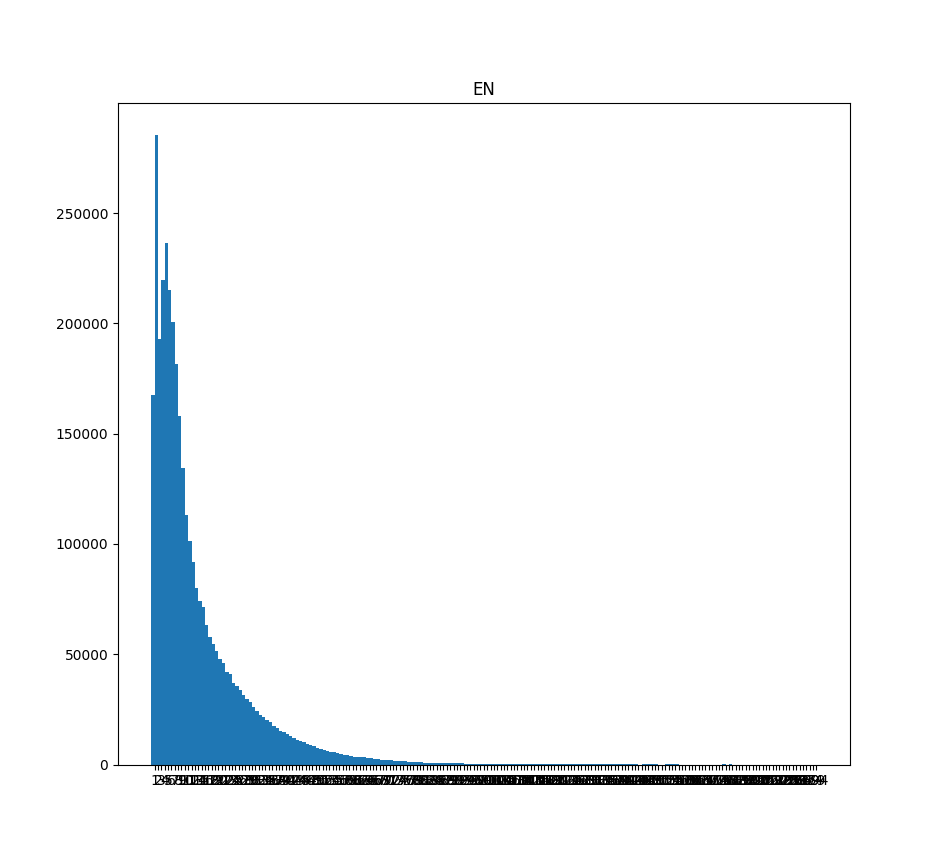

In [141]:
draw_bar_plot("EN", c.corpus_sentence_counter(en_train[REGEXP]))
    

<IPython.core.display.Javascript object>


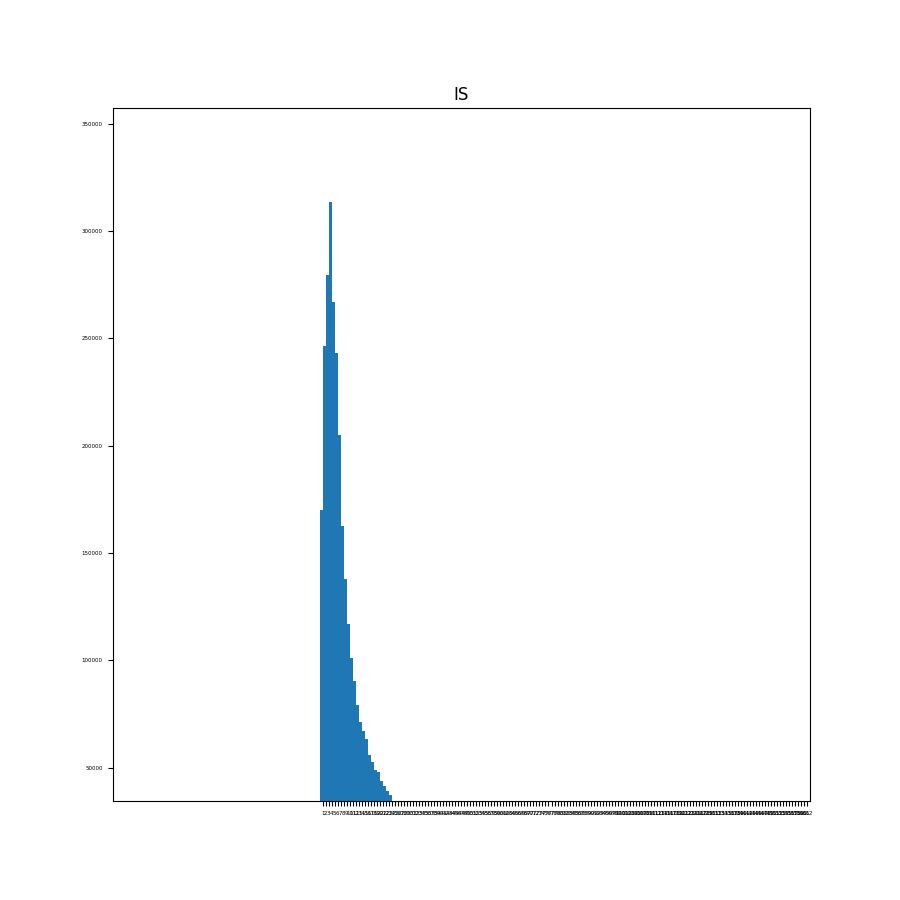

In [142]:
draw_bar_plot("IS", c.corpus_sentence_counter(is_train[REGEXP]))
    

<IPython.core.display.Javascript object>


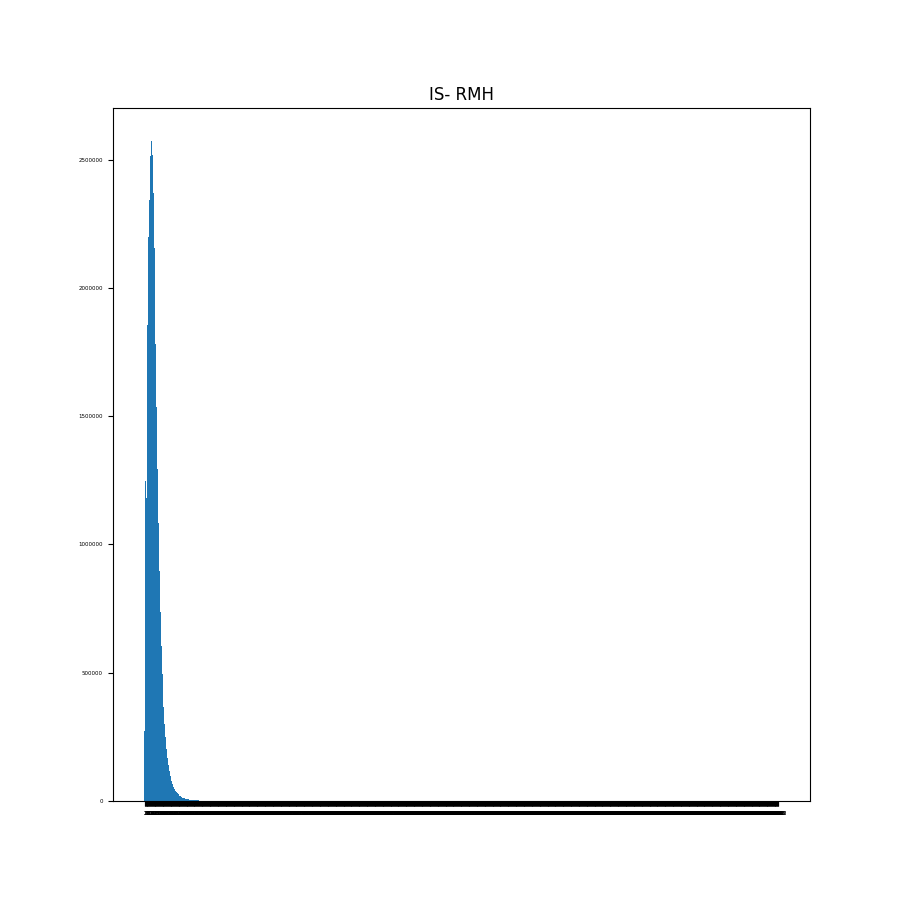

In [143]:
draw_bar_plot("IS-RMH", c.corpus_sentence_counter(rmh[REGEXP]))

### Fjöldi tákna og tíðni

In [6]:
en_counter = c.corpus_token_counter(en_train[REGEXP])
is_counter = c.corpus_token_counter(is_train[REGEXP])
rmh_counter = c.corpus_token_counter(rmh[REGEXP])

Fjöldi mismunandi orða.

In [7]:
pprint(len(en_counter))
pprint(len(is_counter))
pprint(len(rmh_counter))

378034
630448
5621932


In [148]:
import random
pprint(random.sample(rmh_counter.most_common(), 30))

[('brucekaupir', 1),
 ('tengdasonunum', 49),
 ('undirstöðuáfanga', 2),
 ('tökudrengur', 4),
 ('14.309', 2),
 ('pyk', 3),
 ('kjúklingaballentínan', 1),
 ('goffrado', 2),
 ('6600194', 1),
 ('52501', 1),
 ('culicaides', 1),
 ('misstan', 4),
 ('matmælaverð', 1),
 ('33.866', 2),
 ('deadman', 8),
 ('pittí', 1),
 ('kevindebrunye', 1),
 ('eiðslunni', 1),
 ('þinglesin', 308),
 ('rsagði', 1),
 ('lágmarkstækjaeign', 1),
 ('nærinnrauð', 2),
 ('kómet', 1),
 ('auðvaldsklíka', 1),
 ('loftfimleikamann', 5),
 ('knúk', 1),
 ('181.142', 1),
 ('oprandi', 2),
 ('lífsannar', 1),
 ('gelneglur', 30)]


Fjöldi orða.

In [150]:
pprint(f"{'Ensk orð: ':<20}{sum(value for key, value in en_counter.items()):>15}")
pprint(f"{'Íslensk orð: ':<20}{sum(value for key, value in is_counter.items()):>15}")
pprint(f"{'Íslensk orð (RMH): ':<20}{sum(value for key, value in rmh_counter.items()):>15}")

'Ensk orð:                  49940262'
'Íslensk orð:               46731475'
'Íslensk orð (RMH):       1414383094'


## Fjarlægja slæmar línur
Núna búum við til safn af "íslenskum" orðum frá RMH og förum yfir íslenskar setningar í ParIce og athugum hversu stórt hlutfall af orðunum í ParIce-IS eru í safninu okkar.

In [8]:
is_words = set(rmh_counter.keys())
len(is_words)

5621932

In [23]:
# Setting the chunksize higher is better here.
print(c.CHUNKSIZE)
c.CHUNKSIZE = 50000
print(c.CHUNKSIZE)

20000
50000


In [24]:
skip_lines = c.corpus_get_skip_lines(is_train[REGEXP],
                                     [c.REGEXP_SUB['CRYLLIC'][0],
                                      c.REGEXP_SUB['GREEK'][0],
                                      c.REGEXP_SUB['UNKNOWN-CHARS'][0]
                                     ],
                                     is_words,
                                     keep_ratio=0.8,
                                     normalize=True,
                                     keep_sent_length=1)


100%|██████████| 3540825/3540825 [03:39<00:00, 16135.45it/s]


In [15]:
# дейност, είδοσ, εγκατάστασησ, казеин, приложение, ž č š лицата, 12052
print(c.sent_contains_regexp(print_line(13381, en_train[REGEXP]), c.REGEXP_SUB['CRYLLIC'][0]))

True


In [283]:
def hex_values(sentence):
    for c in sentence:
        print(hex(ord(c)))

0x2022


In [56]:
lines = [number for number, fraction, line in skip_lines]

In [17]:
!grep -n "Георги" {is_train[REGEXP]}

In [18]:
if 2935276 in lines:
    print("gone")

fraction removed: 0.0451

In [61]:
print("new fraction", (1 - (c.corpus_info(is_train[REGEXP])[2] - len(lines))/c.corpus_info(is_train[REGEXP])[2]))

new fraction 0.045942965269393454


In [28]:
pprint(skip_lines[:100])

[(13,
  0.7692307692307693,
  'lýsing á útliti urorec og pakkningastærðir urorec 8 mg eru hvít , ógegnsæ , '
  'hörð gelatínhylki .\n'),
 (39, 0.5, 'hycamtin 0,25 mg\n'),
 (49, 0.6666666666666666, 'venjulegur rannsóknarstofubúna ur\n'),
 (56,
  0.7272727272727273,
  'ekki snerta nálarnar eða gúmmítappann á rilonacept regeneron hettuglasinu '
  'með höndunum .\n'),
 (90, 0.3333333333333333, 'rafstöðuskilja eða pokasía\n'),
 (133, 0.6666666666666666, '2. hönnun á prófunarfleti\n'),
 (151, 0.5, '• tengingarbundið gaumljós\n'),
 (192,
  0.7857142857142857,
  'við eftirlit með virknistigi novothirteen er mælt með notkun hefðbundins '
  'prófs á virkni fxiii .\n'),
 (194,
  0.0,
  '• u - gildi óþynnts útblásturslofts á grundvelli eiginleika kjörgass við λ '
  '= 2 , þurrt loft , 273 k , 101,3 kpa\n'),
 (204,
  0.75,
  '- australian quarantine and inspection service ( aqis ) ( landbúnaðar-, '
  'fiskvinnslu- og skógarnytjadeild )\n'),
 (246,
  0.7777777777777778,
  'engin reynsla er af notkun

Núna hendum við þessum slæmu línum úr þjálfunargögnunum.

In [50]:
lines = [2]
a = list(lines)
a.pop(0)
lines

[2]

In [57]:
IN = REGEXP
OUT = DROP

en_train[OUT] = c.corpus_create_path(en_train[IN], OUT)
is_train[OUT] = c.corpus_create_path(is_train[IN], OUT)

c.corpus_skip_lines(en_train[IN], en_train[OUT], lines_in=lines)
c.corpus_skip_lines(is_train[IN], is_train[OUT], lines_in=lines)

True

In [58]:
pprint(c.corpus_info_formatted(en_train[DROP]))
pprint(c.corpus_info_formatted(is_train[DROP]))

'/work/data/parice/train/drop.en            248.6MiB       3378149'
'/work/data/parice/train/drop.is            264.9MiB       3378149'


In [59]:
print(*c.corpora_peek((is_train[REGEXP], en_train[REGEXP]), length=6))

is: í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma .
 en: in these cases , smaller bilge wells to cover a reasonable period of time may be permitted .
 is: • hættuflokka 3.1 til 3.6 , 3.7 , skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun , 3.8 , áhrif önnur en sljóleiki , 3.9 og 3.10 ,
 en: • hazard classes 3.1 to 3.6 , 3.7 adverse effects on sexual function and fertility or on development , 3.8 effects other than narcotic effects , 3.9 and 3.10 ;
 is: rannsóknir á eiturverkunum eftir endurtekna skammta leiddu í ljós frymisbólumyndun á nýrnapíplum og bentu rannsóknir sterklega til að þessi áhrif væru afturkallanleg .
 en: repeated-dose toxicity studies revealed vacuolation of the tubular cells of the kidneys , with strong evidence for reversibility of the effect .
 is: samtímismeðferð með meðalmiklum cyp 3 a 4 hemlum ( til dæmis dílítazem , verapamíl , klarítrómýcín , etýtrómýcín , aprepítant , amíódarón ) skal aðeins gefin m

### Keyra Kvist
Núna keyrum við Kvist á íslensku hlið gagnanna. Þetta er gert til þess að fækkja fjölda óþekktra orða og vonandi auðvelda þýðingar. Við þurfum að gera þessa vinnslu á `train`, `test` og `val`. Til þess að geta keyrt Kvist, þarf forritið (`kvistur.py`) að vera aðgengilegt í núverandi skrá með nauðsynlegum gögnum (`resources`). Kvist er ekki deilt með þessu kerfi.

Áður en Kvistur er keyrður erum við með eftirfarandi fjölda íslenskra orða, samtals.
- 'Íslensk orð:               46.731.475'
- 'Íslensk orð (RMH):       1.414.383.094'

Og fjöldi ólíkra orða:
- 630.448
- 5.621.932

Við búumst við að fyrri tölurnar hækki og seinni tölurnar lækki.

In [4]:
import kvistur
import os

resources = {
    "modifiers": os.path.join('resources', 'modifiers.dawg'),
    "heads": os.path.join('resources', 'heads.dawg'),
    "templates": os.path.join('resources', 'templates.dawg'),
    "splits": os.path.join('resources', 'splits.dawg')
}
kv = kvistur.Kvistur(**resources)
words = ["sveitarstjórnarkosningarnar", "kosningarnar", "landbúnaðarframleiðslunnar"]


In [11]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

def sent_kvistur(sentence: str):
    result = []
    # we leave the \n
    words = sentence.split(" ")
    for word in words:
        score, tree = kv.decompound(word)
        if tree.get_binary_split():
            result.extend(tree.get_binary_split())
        else:
            result.append(word)
    return " ".join(result)

def corpus_kvistur(path, out_path):
    with ProcessPoolExecutor(max_workers=c.THREADS) as executor:
        with path.open() as f_in:
            f_list = f_in.readlines()
            results = tqdm(executor.map(
                sent_kvistur,
                f_list,
                chunksize=5000),
                total=len(f_list))
    with out_path.open('w+') as f_out:
        for line in results:
            f_out.write(line)

In [12]:
is_train[KVISTUR] = c.corpus_create_path(is_train[DROP], KVISTUR)
is_val[KVISTUR] = c.corpus_create_path(is_val[REGEXP], KVISTUR)
is_test[KVISTUR] = c.corpus_create_path(is_test[REGEXP], KVISTUR)
rmh[KVISTUR] = c.corpus_create_path(rmh[REGEXP], KVISTUR)

corpus_kvistur(is_train[DROP], is_train[KVISTUR])
corpus_kvistur(is_val[REGEXP], is_val[KVISTUR])
corpus_kvistur(is_test[REGEXP], is_test[KVISTUR])
corpus_kvistur(rmh[REGEXP], rmh[KVISTUR])

100%|██████████| 67751125/67751125 [37:51<00:00, 29831.52it/s]      


In [14]:
print(*c.corpus_peek(rmh[KVISTUR]))

karvel pálma son :
 herra for seti .
 það eru aðeins ör fá orð .
 fyrst í til efni af því , sem hæst virtur fjmrh . sagði og vildi ráð leggja mér vinnu brögð , þá er ég vissu lega þakk látur fyrir það .
 en heldur hefði ég kosið , að þessi ráð legging hefði komið fram fyrr í dag , þannig að ég hefði getað nýtt þann tíma , sem farið hefur í það hjá stjórnar liðinu að semja um það , sem hér á að fara fram í dag eða á morgun , hátt í 2 klukku tíma í dag , og þá hefði ég vissu lega þegið þá á bendingu að kynna mér frekar , hvað hv . þing maður .
 sjálfstfl . hefðu sagt um ýmis mál hér á undan förnum vikum eða mánuðum .
 ég heyrði það ekki í ræðu hæst virtur fjmrh . , þegar hann talaði hér á eftir már , að hann viki einu orði að því að rengja þær upp lýsingar , sem ég var hér með um stöðu ríkis sjóðs og eru skjal festar á blaði frá hans fyrir rennara , hæst virtur nú verandi samgöngu ráðherra .
 ég heyrði ekki , að hann ýjaði að því einu orði , að þær væru rangar , og ég vil ein dregið kref

In [15]:
kvistur_counter = c.corpus_token_counter(is_train[KVISTUR])
kvistur_rmh_counter = c.corpus_token_counter(rmh[KVISTUR])

In [18]:
print(len(kvistur_counter))
print(len(kvistur_rmh_counter))

292079
2754439


In [17]:
pprint(f"{'Íslensk orð (Kvistur): ':<20}{sum(value for key, value in kvistur_counter.items()):>15}")
pprint(f"{'Íslensk orð (Kvistur, RMH): ':<20}{sum(value for key, value in kvistur_rmh_counter.items()):>15}")

'Íslensk orð (Kvistur):        52592991'
'Íslensk orð (Kvistur, RMH):      1633763707'


### BPE
Núna prófum við að nota BPE á textann.

### Skrifa sem endanleg skjöl
Til þess að samhæfa á móti þjálfun þá afritum við gögnin úr síðasta skrefið og endurnefnum.

In [60]:
OUT = FINAL

en_train[OUT] = c.corpus_create_path(en_train[DROP], OUT)
is_train[OUT] = c.corpus_create_path(is_train[DROP], OUT)
en_val[OUT] = c.corpus_create_path(en_val[REGEXP], OUT)
is_val[OUT] = c.corpus_create_path(is_val[REGEXP], OUT)
en_test[OUT] = c.corpus_create_path(en_test[REGEXP], OUT)
is_test[OUT] = c.corpus_create_path(is_test[REGEXP], OUT)
rmh[OUT] = c.corpus_create_path(rmh[REGEXP], OUT)

!cp {en_train[DROP]} {en_train[OUT]}
!cp {is_train[DROP]} {is_train[OUT]}
!cp {en_val[REGEXP]} {en_val[OUT]}
!cp {is_val[REGEXP]} {is_val[OUT]}
!cp {en_test[REGEXP]} {en_test[OUT]}
!cp {is_test[REGEXP]} {is_test[OUT]}
!cp {rmh[REGEXP]} {rmh[OUT]}